# Evaluate

Can seasonal forecasts be used as 'alternate' realities? Here we show how a set of evaluation metrics can be used to answer this question. The evaluation metrics are available through an [R package](https://github.com/timokelder/UNSEEN) for easy evaluation of the UNSEEN ensemble. Here, we illustrate how this package can be used in the UNSEEN workflow.  We will evaluate the generated UNSEEN ensemble of UK February precipitation and of MAM Siberian heatwaves. 

The framework to evaluate the UNSEEN ensemble presented here consists of testing the ensemble member independence, model stability and model fidelity, see also [NPJ preprint](https://eartharxiv.org/hyxeq/).

<div class="alert alert-info">

Note

This is R code and not python!
    
We switch to R since we believe R has a better functionality in extreme value statistics. 

</div>

We load the UNSEEN package and read in the data.

In [1]:
setwd('../../..')
getwd()

[1] "/lustre/soge1/projects/ls/personal/timo/UNSEEN-open"

In [2]:
library(UNSEEN)

The data that is imported here are the files stored at the end of the [preprocessing step](../2.Preprocess/2.Preprocess.ipynb).


In [3]:
SEAS5_Siberia_events <- read.csv("Data/SEAS5_Siberia_events.csv", stringsAsFactors=FALSE)
ERA5_Siberia_events <- read.csv("Data/ERA5_Siberia_events.csv", stringsAsFactors=FALSE)

In [4]:
SEAS5_Siberia_events_zoomed <- read.csv("Data/SEAS5_Siberia_events_zoomed.csv", stringsAsFactors=FALSE)
ERA5_Siberia_events_zoomed <- read.csv("Data/ERA5_Siberia_events_zoomed.csv", stringsAsFactors=FALSE)

In [5]:
SEAS5_Siberia_events$t2m <- SEAS5_Siberia_events$t2m - 273.15
ERA5_Siberia_events$t2m <- ERA5_Siberia_events$t2m - 273.15
SEAS5_Siberia_events_zoomed$t2m <- SEAS5_Siberia_events_zoomed$t2m - 273.15
ERA5_Siberia_events_zoomed$t2m <- ERA5_Siberia_events_zoomed$t2m - 273.15


In [6]:
head(SEAS5_Siberia_events_zoomed,n = 3)
head(ERA5_Siberia_events, n = 3)

,year,leadtime,number,t2m
,<int>,<int>,<int>,<dbl>
1,1982,2,0,-3.736505
2,1982,2,1,-5.682759
3,1982,2,2,-4.221411


,year,t2m
,<int>,<dbl>
1,1979,4.010750
2,1980,3.880965
3,1981,4.822891


In [7]:
EOBS_UK_weighted_df <- read.csv("Data/EOBS_UK_weighted_upscaled.csv", stringsAsFactors=FALSE)
SEAS5_UK_weighted_df <- read.csv("Data/SEAS5_UK_weighted_masked.csv", stringsAsFactors=FALSE)

And then convert the time class to Date format, with the ymd function in lubridate:

In [8]:
EOBS_UK_weighted_df$time <- lubridate::ymd(EOBS_UK_weighted_df$time)
str(EOBS_UK_weighted_df)

EOBS_UK_weighted_df_hindcast <- EOBS_UK_weighted_df[
    EOBS_UK_weighted_df$time > '1982-02-01' &
    EOBS_UK_weighted_df$time < '2017-02-01',
    ]


SEAS5_UK_weighted_df$time <- lubridate::ymd(SEAS5_UK_weighted_df$time)
str(SEAS5_UK_weighted_df)

'data.frame':	71 obs. of  2 variables:
 $ time: Date, format: "1950-02-28" "1951-02-28" ...
 $ rr  : num  4.13 3.25 1.07 1.59 2.59 ...
'data.frame':	9945 obs. of  4 variables:
 $ leadtime: int  2 2 2 2 2 2 2 2 2 2 ...
 $ number  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ time    : Date, format: "1982-02-01" "1983-02-01" ...
 $ tprate  : num  1.62 2.93 3.27 2 3.31 ...


## Timeseries

Here we plot the timeseries of SEAS5 (UNSEEN) and ERA5 (OBS) for the entire domain and a zoomed domain for the Siberian Heatwave. 

Warning message:
“replacing previous import ‘vctrs::data_frame’ by ‘tibble::data_frame’ when loading ‘dplyr’”
Warning message:
“Removed 2756 rows containing non-finite values (stat_boxplot).”


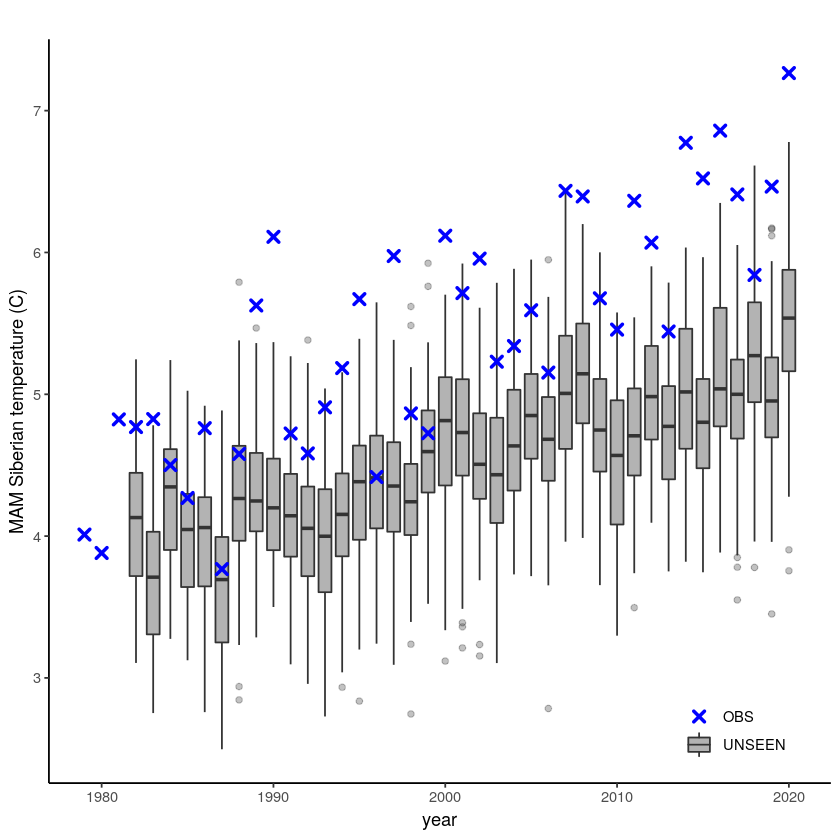

In [9]:
unseen_timeseries(
    ensemble = SEAS5_Siberia_events,
    obs = ERA5_Siberia_events,
    ensemble_yname = "t2m",
    ensemble_xname = "year",
    obs_yname = "t2m",
    obs_xname = "year",
    ylab = "MAM Siberian temperature (C)")

Warning message:
“Removed 2756 rows containing non-finite values (stat_boxplot).”


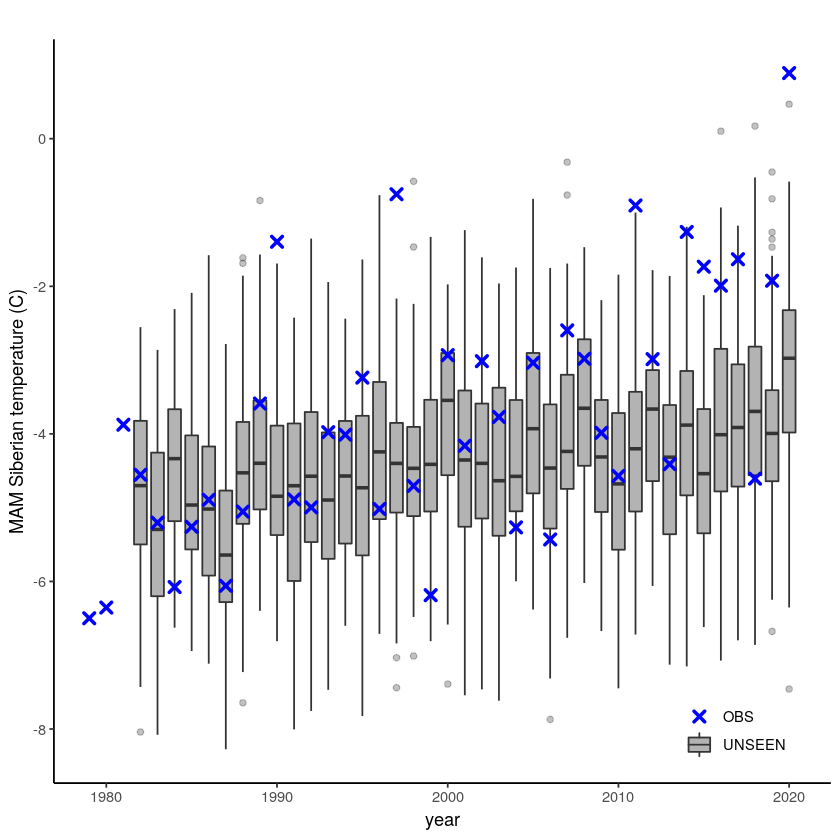

In [10]:
unseen_timeseries(
    ensemble = SEAS5_Siberia_events_zoomed,
    obs = ERA5_Siberia_events_zoomed,
    ensemble_yname = "t2m",
    ensemble_xname = "year",
    obs_yname = "t2m",
    obs_xname = "year",
    ylab = "MAM Siberian temperature (C)")

This shows that there is a temperature trend over the entire domain. Here we will continue with the 'zoomed' domain because it better describes the 2020 event. 

The timeseries consist of hindcast (years 1982-2016) and archived forecasts (years 2017-2020). The datasets are slightly different: the hindcasts contains 25 members whereas operational forecasts contain 51 members, the native resolution is different and the dataset from which the forecasts are initialized is different. 

**For the evaluation of the UNSEEN ensemble we want to only use the SEAS5 hindcasts for a consistent dataset.** Note, 2017 is not used in either the hindcast nor the operational dataset in this example, since it contains forecasts both initialized in 2016 (hindcast) and 2017 (forecast), see [retrieve](../1.Download/1.Retrieve.ipynb).
We split SEAS5 into hindcast and operational forecasts:

In [11]:
SEAS5_Siberia_events_zoomed_hindcast <- SEAS5_Siberia_events_zoomed[
    SEAS5_Siberia_events_zoomed$year < 2017 &
    SEAS5_Siberia_events_zoomed$number < 25,]

SEAS5_Siberia_events_zoomed_forecasts <- SEAS5_Siberia_events_zoomed[
    SEAS5_Siberia_events_zoomed$year > 2017,]


And we select the same years for ERA5. 

In [12]:
ERA5_Siberia_events_zoomed_hindcast <- ERA5_Siberia_events_zoomed[
    ERA5_Siberia_events_zoomed$year < 2017 &
    ERA5_Siberia_events_zoomed$year > 1981,]

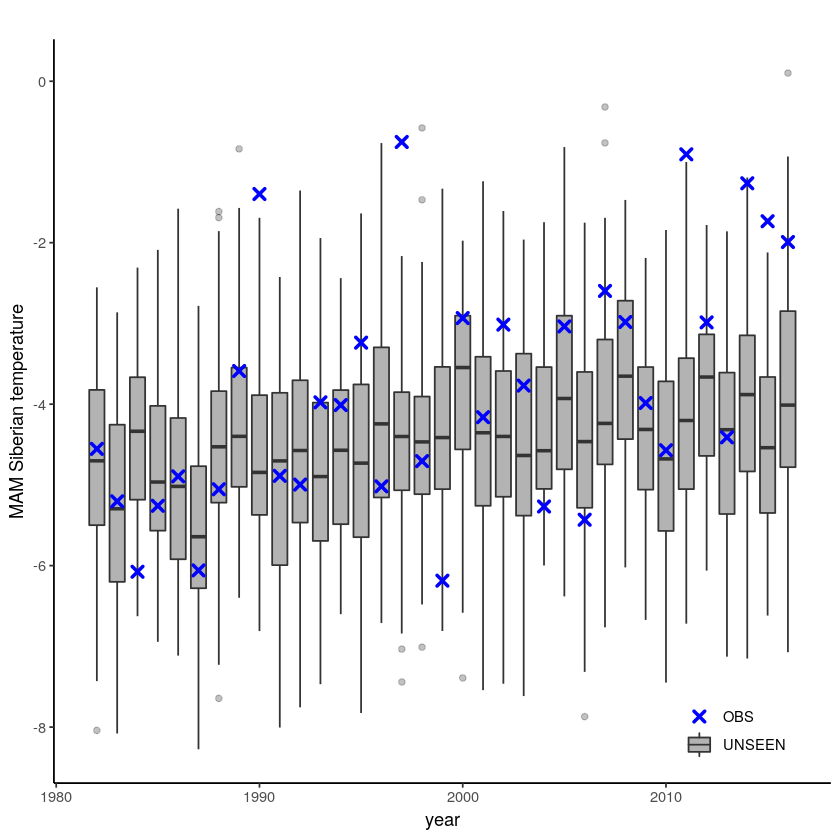

In [13]:
unseen_timeseries(
    ensemble = SEAS5_Siberia_events_zoomed_hindcast,
    obs = ERA5_Siberia_events_zoomed_hindcast,
    ensemble_yname = "t2m",
    ensemble_xname = "year",
    obs_yname = "t2m",
    obs_xname = "year",
    ylab = "MAM Siberian temperature")

 

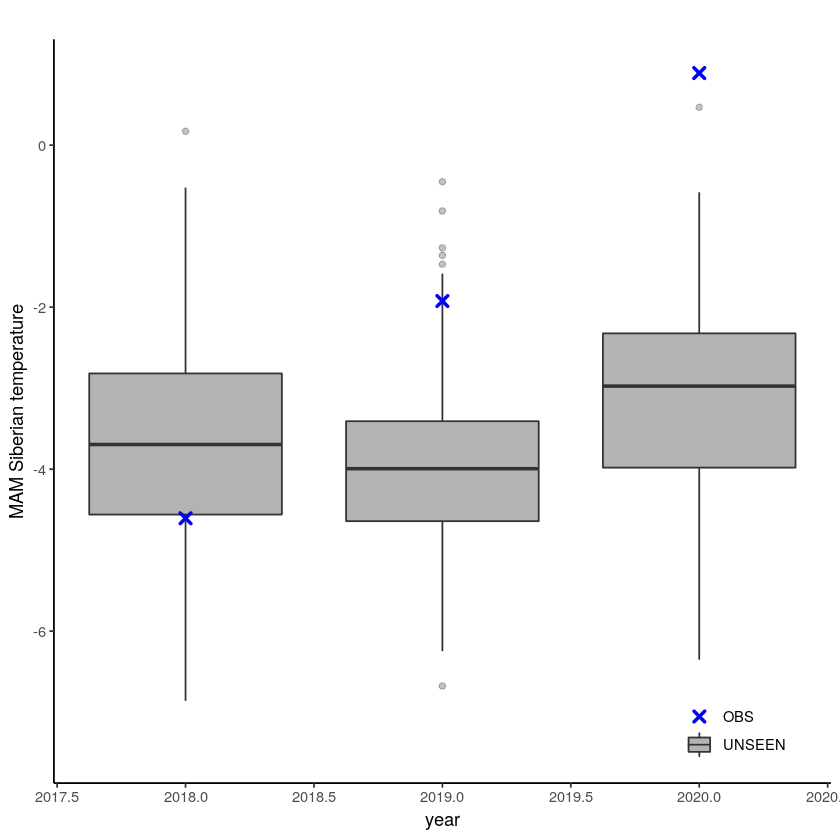

In [14]:
unseen_timeseries(
    ensemble = SEAS5_Siberia_events_zoomed_forecasts,
    obs = ERA5_Siberia_events_zoomed[ERA5_Siberia_events_zoomed$year > 2017,],
    ensemble_yname = "t2m",
    ensemble_xname = "year",
    obs_yname = "t2m",
    obs_xname = "year",
    ylab = "MAM Siberian temperature")

For the UK we have a longer historical record available from EOBS:

Warning message:
“Removed 4654 rows containing non-finite values (stat_boxplot).”


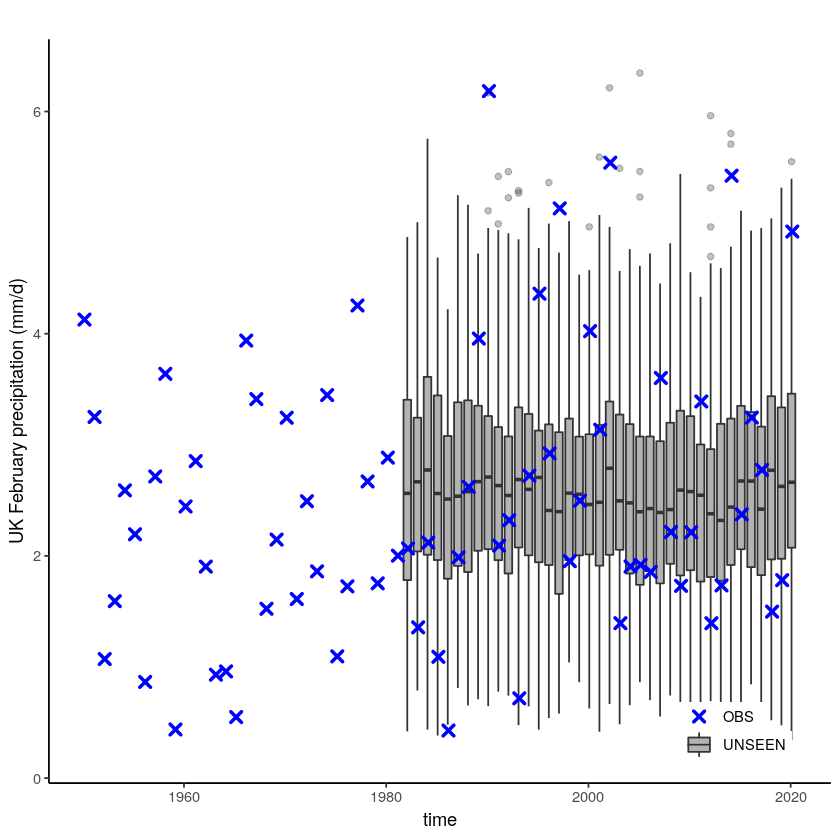

In [15]:
unseen_timeseries(ensemble = SEAS5_UK_weighted_df,
                  obs = EOBS_UK_weighted_df,
                  ylab = 'UK February precipitation (mm/d)')

Warning message:
“Removed 4654 rows containing non-finite values (stat_boxplot).”


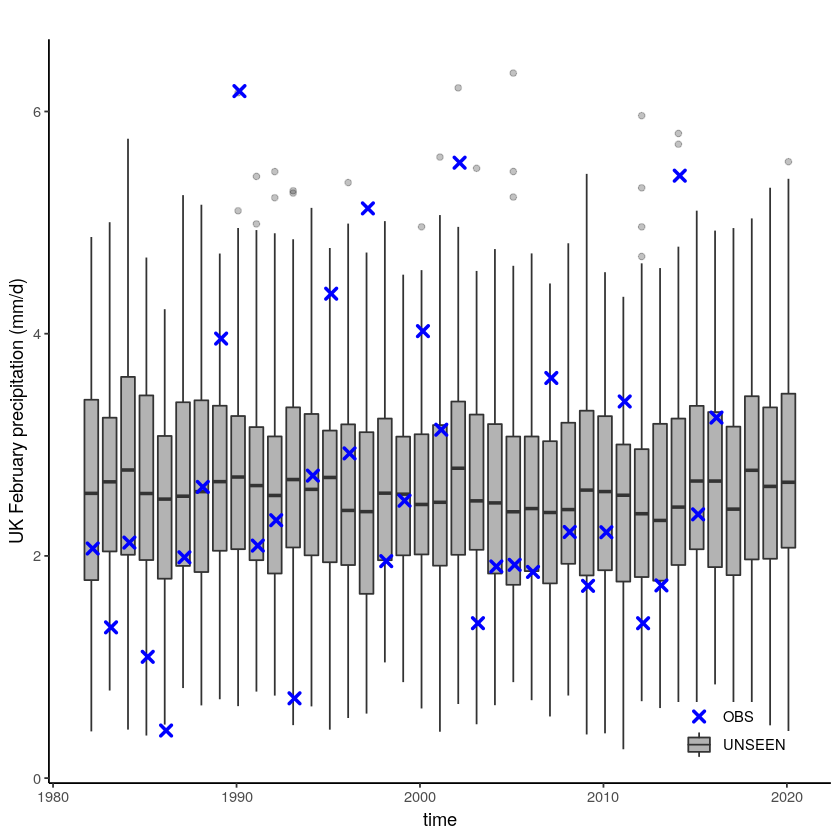

In [16]:
unseen_timeseries(ensemble = SEAS5_UK_weighted_df,
                  obs = EOBS_UK_weighted_df_hindcast,
                  ylab = 'UK February precipitation (mm/d)')

Call the documentation of the function with `?unseen_timeseries`

## Independence

Significance ranges need fixing + detrend method (Rob)

Warning message:
“Removed 975 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 975 rows containing non-finite values (stat_boxplot).”


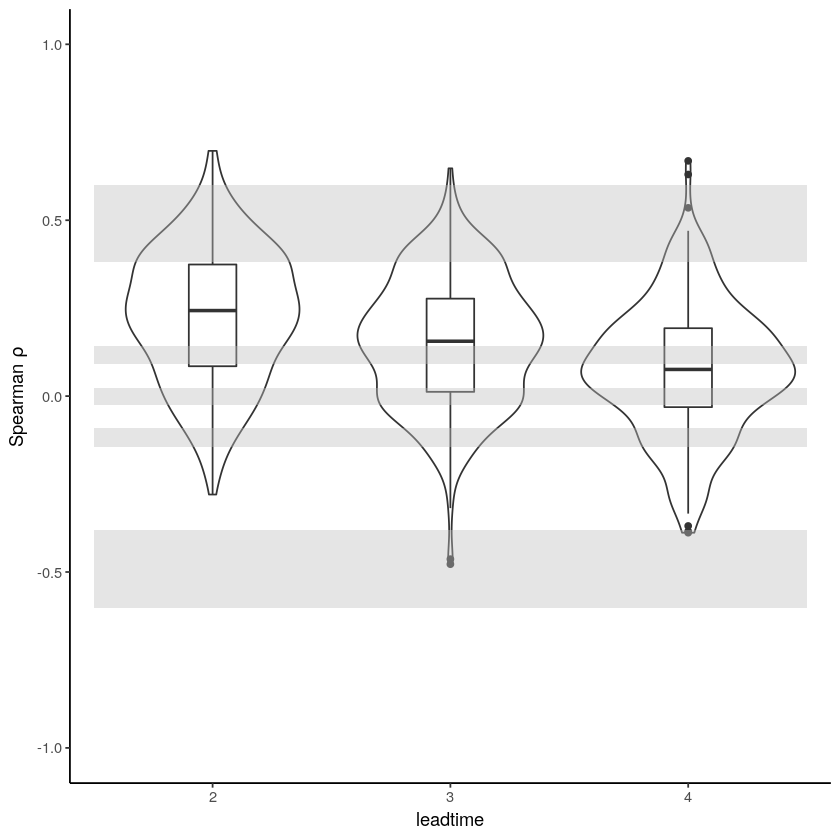

In [17]:
independence_test(
    ensemble = SEAS5_Siberia_events,
    n_lds = 3,
    var_name = "t2m",
)

Warning message:
“Removed 975 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 975 rows containing non-finite values (stat_boxplot).”


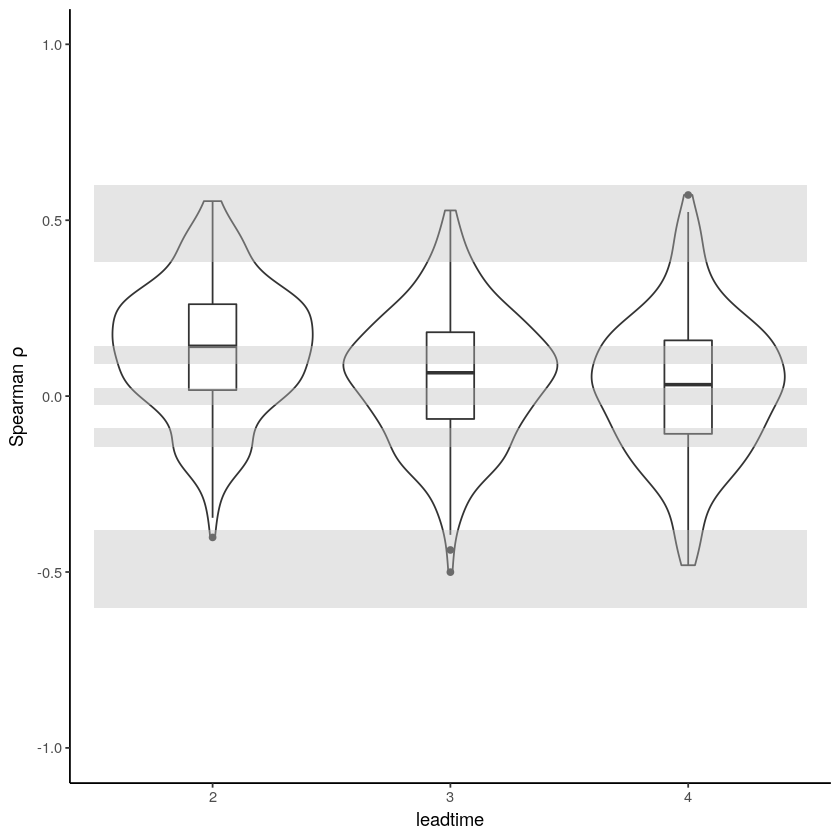

In [18]:
independence_test(
    ensemble = SEAS5_Siberia_events_zoomed,
    n_lds = 3,
    var_name = "t2m",
)

Warning message:
“Removed 1625 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 1625 rows containing non-finite values (stat_boxplot).”


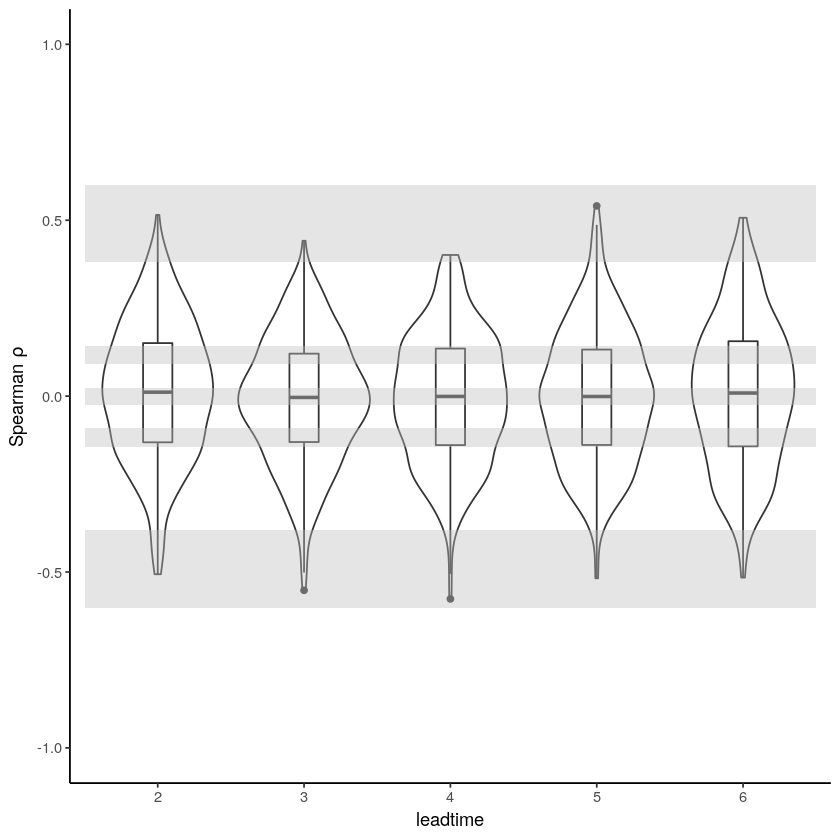

In [19]:
independence_test(ensemble = SEAS5_UK_weighted_df)

## Stability

For the stability test we assess whether the events get more severe with leadtime, due to a potential 'drift' in the model. We need to use the consistent hindcast dataset for this.

Warning message:
“Removed 2 row(s) containing missing values (geom_path).”


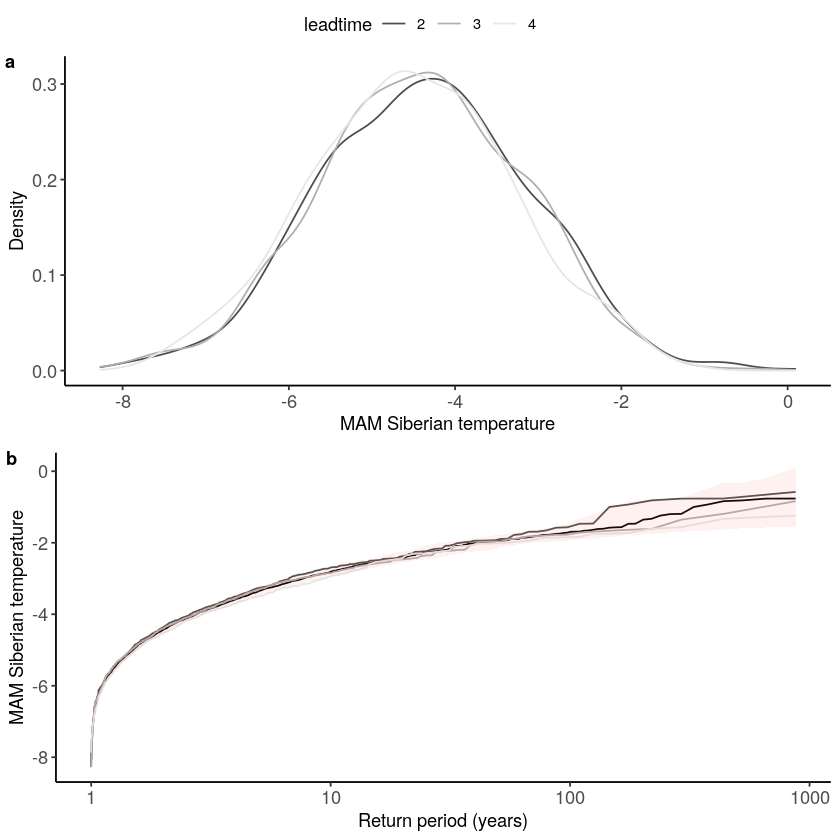

In [20]:
stability_test(
    ensemble = SEAS5_Siberia_events_zoomed_hindcast,
    lab = 'MAM Siberian temperature',
    var_name = 't2m'
)

Warning message:
“Removed 4 row(s) containing missing values (geom_path).”


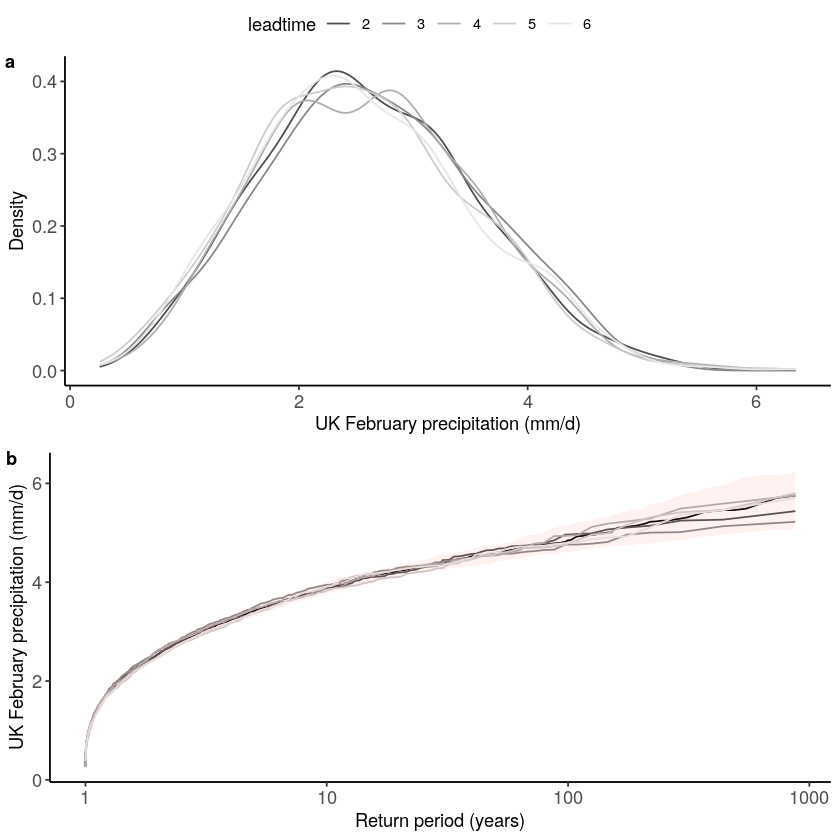

In [21]:
stability_test(ensemble = SEAS5_UK, lab = 'UK February precipitation (mm/d)')

## Fidelity

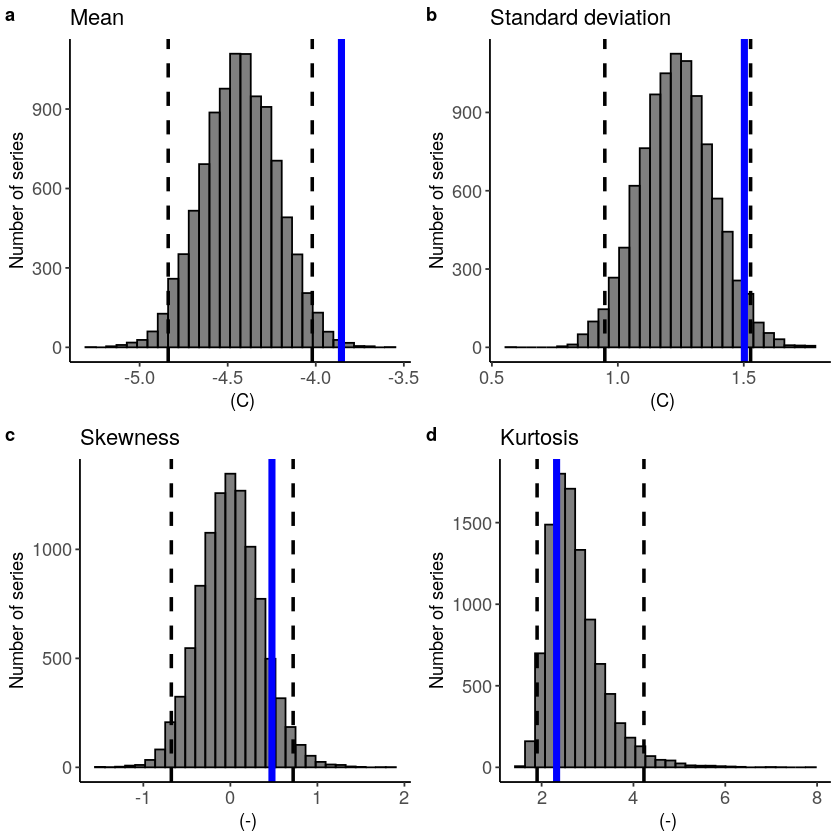

In [22]:
fidelity_test(
    obs = ERA5_Siberia_events_zoomed_hindcast$t2m,
    ensemble = SEAS5_Siberia_events_zoomed_hindcast$t2m,
    units = 'C',
    biascor = FALSE
)

Lets apply a additive biascor


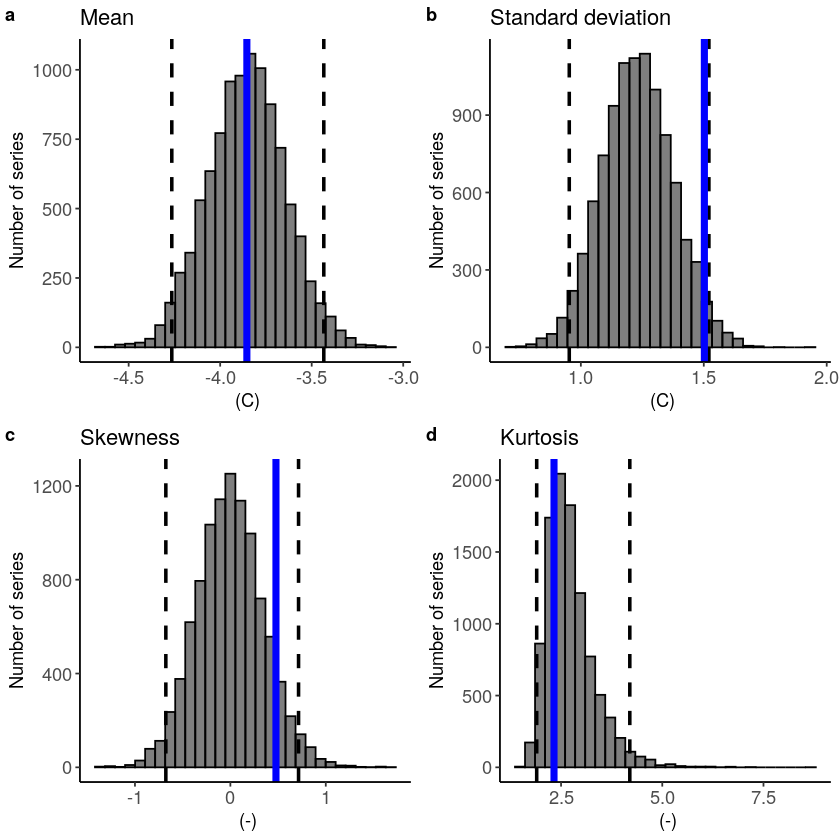

In [23]:
#Lets apply a additive biascor
obs = ERA5_Siberia_events_zoomed_hindcast$t2m
ensemble = SEAS5_Siberia_events_zoomed_hindcast$t2m
ensemble_biascor = ensemble + (mean(obs) - mean(ensemble))

fidelity_test(
    obs = obs,
    ensemble = ensemble_biascor,
    units = 'C',
    biascor = FALSE
)

# Illustrate

Here we use extreme value theory (EVT) to fit extreme value distributions to the SEAS5 (UNSEEN) and ERA5 (observed) data. 

To see example applications, have a look at the examples:

* [Siberian Heatwave](https://unseen-open.readthedocs.io/en/latest/Notebooks/examples/Siberian_Heatwave.html)
* [California fires](https://unseen-open.readthedocs.io/en/latest/Notebooks/examples/California_Fires.html)
* [UK Precipitation](https://unseen-open.readthedocs.io/en/latest/Notebooks/examples/UK_Precipitation.html)

We define a function to plot the extreme value distributions:

In [75]:
library(extRemes)
library(ggplot2)
library(ggpubr)

EVT_plot <- function(obs, ensemble, GEV_type, main, y_lab = "February average precipitation (mm/day)", ylim = NA) {
  ## We plot the GEV distribution for ERA5 and empirical data for SEAS5
  fit_obs <- fevd(
    x = obs, threshold = NULL, threshold.fun = ~1, location.fun = ~1,
    scale.fun = ~1, shape.fun = ~1, use.phi = FALSE,
    type = GEV_type, method = "MLE", initial = NULL, # type= c("GEV", "GP", "PP", "Gumbel", "Exponential"), method= c("MLE", "GMLE", "Bayesian", "Lmoments")
    span = NULL, units = NULL, time.units = "days", period.basis = "year", ## time and period only important for labelling and do not influence the calculation
    na.action = na.fail, optim.args = NULL, priorFun = NULL,
    priorParams = NULL, proposalFun = NULL, proposalParams = NULL,
    iter = 9999, weights = 1, blocks = NULL, verbose = FALSE
  )

  ## Now calculate the return levels and their confidence intervals for each return period within rperiods
  rperiods <- c(seq(from = 1.01, to = 1.5, by = 0.1), 1.7, 2, 3, 5, 10, 20, 50, 80, 100, 120, 200, 250, 300, 500, 800, 2000, 5000)
  rvs_obs <- ci.fevd(fit_obs, alpha = 0.05, type = "return.level", return.period = rperiods, method = "normal")
  colnames(rvs_obs) <- c("Obs_l", "Obs", "Obs_h") # Rename the col
  GEV_obs <- data.frame(cbind(rvs_obs, rperiods)) ## Make a datafram for ggplot

  ## Add the emipirical data
  rp_obs <- length(obs) / 1:length(obs) ## these are the (empirical) return periods for the sorted datapoints
  obs_sorted <- sort(obs, decreasing = T) ## For example, the highest extreme has a rp of 35 years, the second highest 17.5, third highest 11.7 etc.
  datapoints_obs <- data.frame(cbind(rp_obs, obs_sorted))


  rp_S5 <- length(ensemble) / 1:length(ensemble) # SEAS5 has return periods up to 3800 years
  ensemble_sorted <- sort(ensemble, decreasing = T)
  datapoints_S5 <- data.frame(cbind(rp_S5, ensemble_sorted))

  ## And plot
  cols <- c("UNSEEN" = "black", "OBS     " = "blue") ## for  the legend
  ggplot(data = datapoints_S5, aes(x = rp_S5)) +
    geom_point(aes(y = ensemble_sorted, col = "UNSEEN"), alpha = 0.5, size = 1) +
    geom_ribbon(data = GEV_obs, aes(ymin = Obs_l, ymax = Obs_h, x = rperiods, fill = "OBS     "), alpha = 0.1) +
    geom_point(data = datapoints_obs, aes(x = rp_obs, y = obs_sorted, col = "OBS     "), size = 1) +
    scale_x_continuous(trans = "log10") +
    scale_fill_manual(name = "Data", values = cols) +
    scale_colour_manual(name = NULL, values = cols) +
    theme_classic() +
    theme(
      legend.position = c(.95, .05),
      legend.justification = c("right", "bottom"),
      legend.box.just = "right",
      legend.title = element_blank(),
      text = element_text(size = 11),
      axis.text = element_text(size = 11)
    ) +
    labs(title = main, y = y_lab, x = "Return period (years)") +
    if (is.finite(ylim)) {
      coord_cartesian(ylim = c(NA, ylim))
    }
}

First, we fit a gumber and a GEV distribution (including shape parameter) to the observed extremes over Siberia. With a likelihood ratio test we show that the Gumbel distribution best describes the data. 

In [84]:
fit_obs_Gumbel <- fevd(x = ERA5_Siberia_events_zoomed_hindcast$t2m,
                    type = "Gumbel"
                   )
fit_obs_GEV <- fevd(x = ERA5_Siberia_events_zoomed_hindcast$t2m,
                    type = "GEV"
                   )
lr.test(fit_obs_Gumbel, fit_obs_GEV)


	Likelihood-ratio Test

data:  ERA5_Siberia_events_zoomed_hindcast$t2mERA5_Siberia_events_zoomed_hindcast$t2m
Likelihood-ratio = 0.21004, chi-square critical value = 3.8415, alpha =
0.0500, Degrees of Freedom = 1.0000, p-value = 0.6467
alternative hypothesis: greater


We show the gumbel plot for the observed (ERA5) and UNSEEN (SEAS5 hindcast data). This shows that the UNSEEN simulations are not within the uncertainty range of the observations. This has likely two reasons, illustrated in the evaluation section: there is some dependence between the events and there is too little variability within the UNSEEN ensemble. 

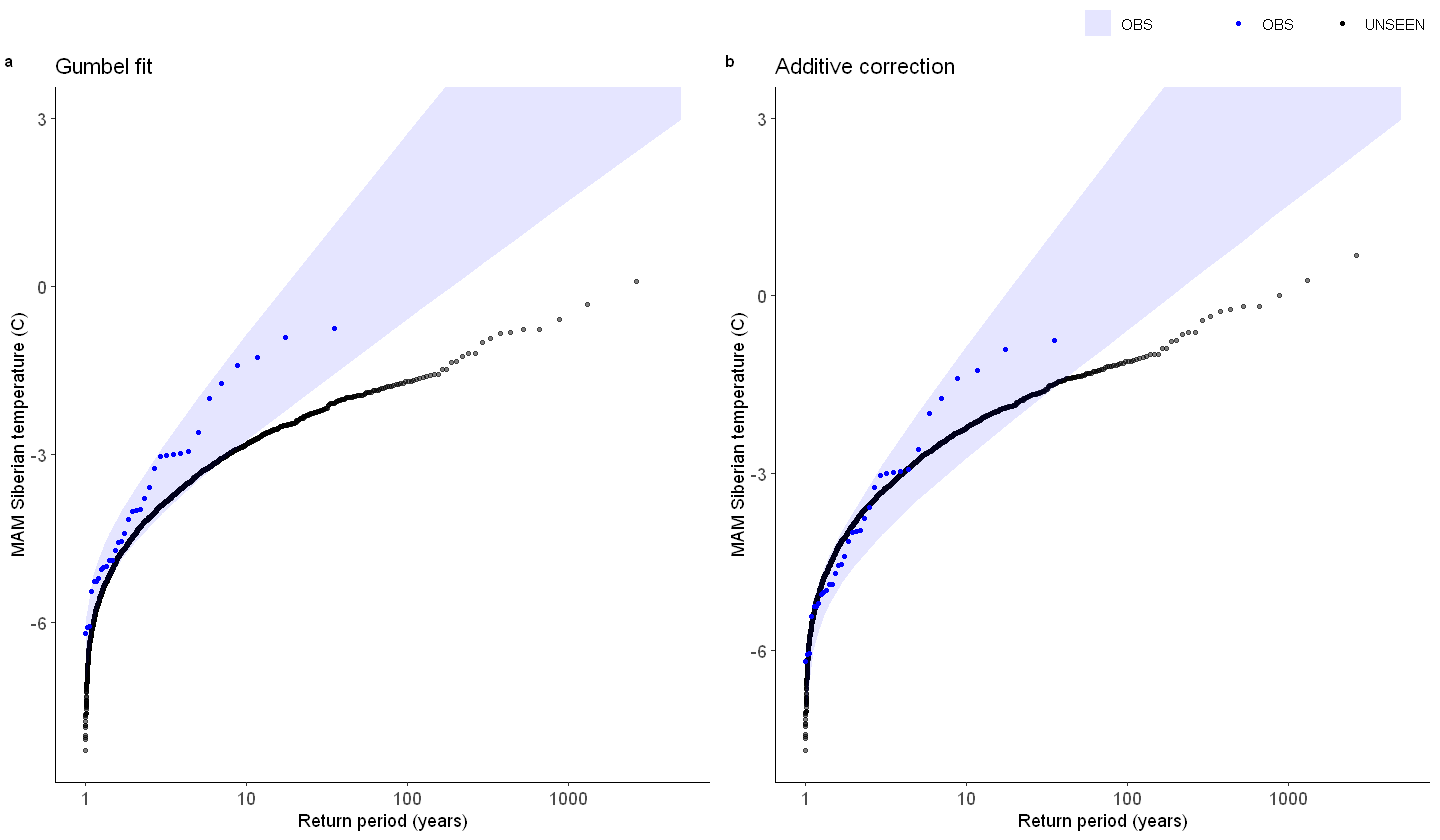

In [100]:
options(repr.plot.width = 12)
GEV_hindcast <- EVT_plot(ensemble = SEAS5_Siberia_events_zoomed_hindcast$t2m,
                         obs = ERA5_Siberia_events_zoomed_hindcast$t2m,
                         main = "Gumbel fit",
                         GEV_type = "Gumbel",
                         ylim = 3,
                         y_lab = 'MAM Siberian temperature (C)'
                        ) 
GEV_hindcast_corrected <- EVT_plot(ensemble = ensemble_biascor, #SEAS5_Siberia_events_zoomed_hindcast$t2m,
                                   obs = ERA5_Siberia_events_zoomed_hindcast$t2m,
                                   main = "Additive correction",
                                   GEV_type = "Gumbel",
                                   ylim = 3,
                                   y_lab = 'MAM Siberian temperature (C)'
                                  ) 

ggarrange(GEV_hindcast, GEV_hindcast_corrected,
  labels = c("a", "b"), # ,"c","d"),
  common.legend = T,
  font.label = list(size = 10, color = "black", face = "bold", family = NULL),
  ncol = 2, nrow = 1
)
# GEV_hindcast
# GEV_hindcast_corrected



So what can we get out of it? What if we look at the operational forecast? Even if we cannot use the dataset as a whole to estimate the likelihood of occurrence, have events similar to the 2020 event occurred?  

We select all archived SEAS5 (UNSEEN) events and all ERA5 (observed) events except for the 2020 event as reference.

In [146]:
ERA5_Siberia_events_zoomed_min1 <- ERA5_Siberia_events_zoomed[1:length(ERA5_Siberia_events_zoomed$t2m)-1,]
ERA5_Siberia_events_zoomed_2020 <- ERA5_Siberia_events_zoomed[length(ERA5_Siberia_events_zoomed$t2m),]
# ERA5_Siberia_events_zoomed_min1
# ERA5_Siberia_events_zoomed_2020

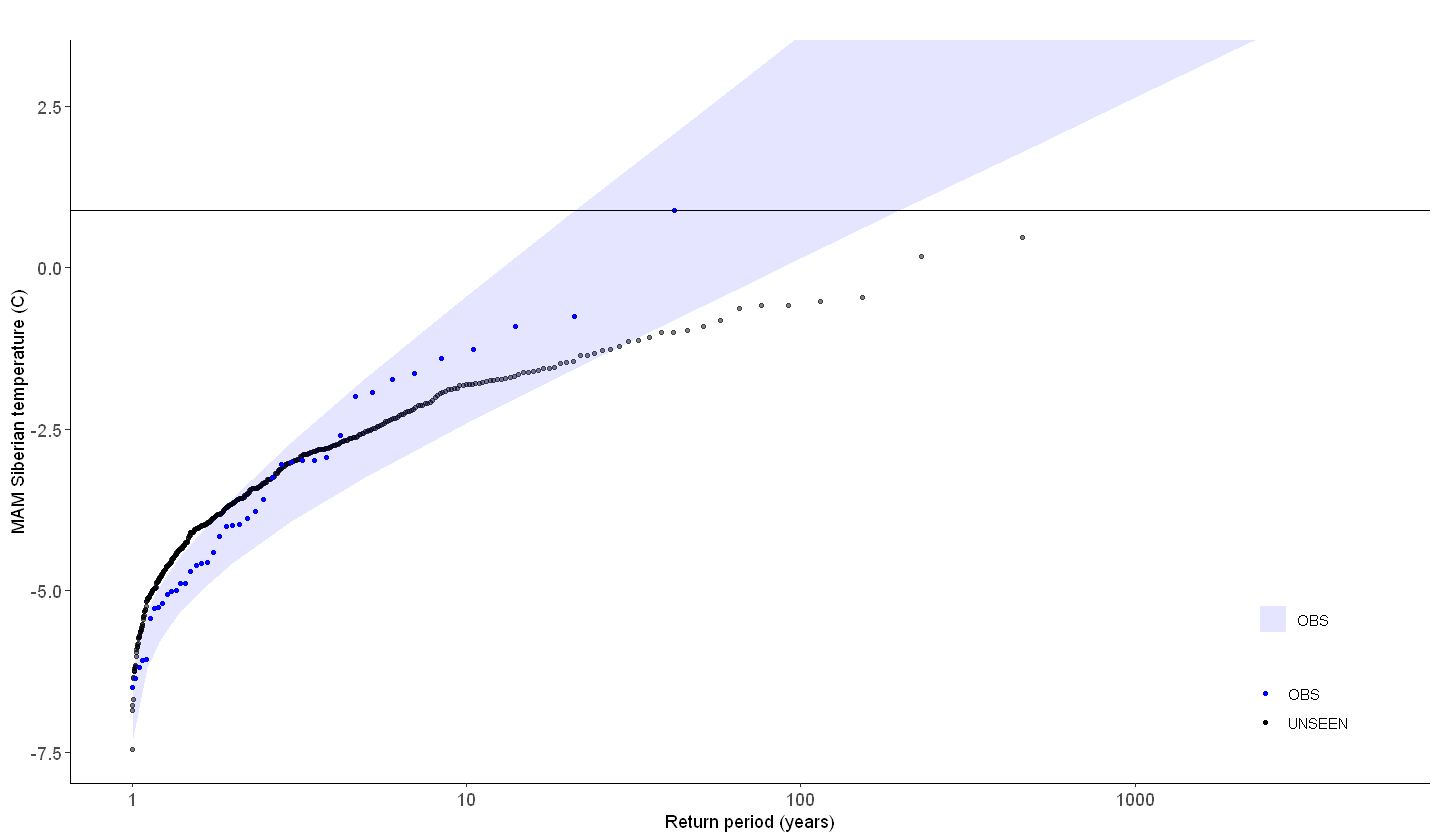

In [151]:
GEV_forecasts <- EVT_plot(ensemble = SEAS5_Siberia_events_zoomed_forecasts$t2m,
                          obs = ERA5_Siberia_events_zoomed$t2m,
                          main = "",
                          GEV_type = "Gumbel",
                          ylim = 3,
                          y_lab = 'MAM Siberian temperature (C)'
                         ) # %>%
GEV_forecasts + geom_hline(yintercept = ERA5_Siberia_events_zoomed_2020$t2m)#,
#     color = "black", linetype = "dashed", size = 1

Plot the GEV distribution:

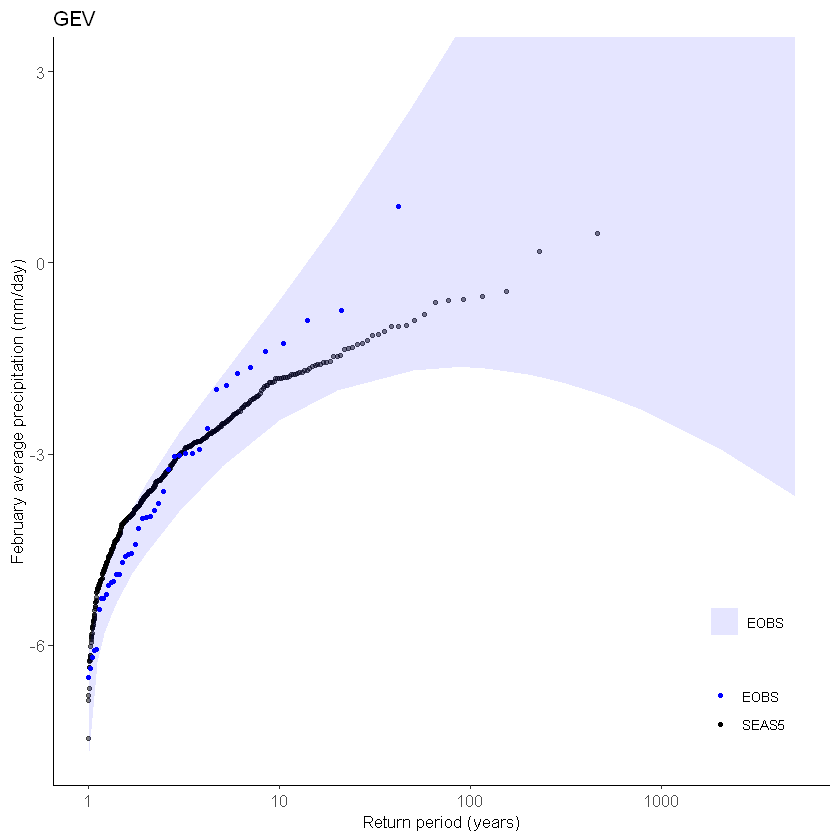

In [63]:
GEV1 <- EVT_plot(ensemble = SEAS5_Siberia_events_zoomed_forecasts$t2m,
                 obs = ERA5_Siberia_events_zoomed$t2m,
                 main = "GEV",
                 GEV_type = "GEV",ylim = 3) # %>%
GEV1

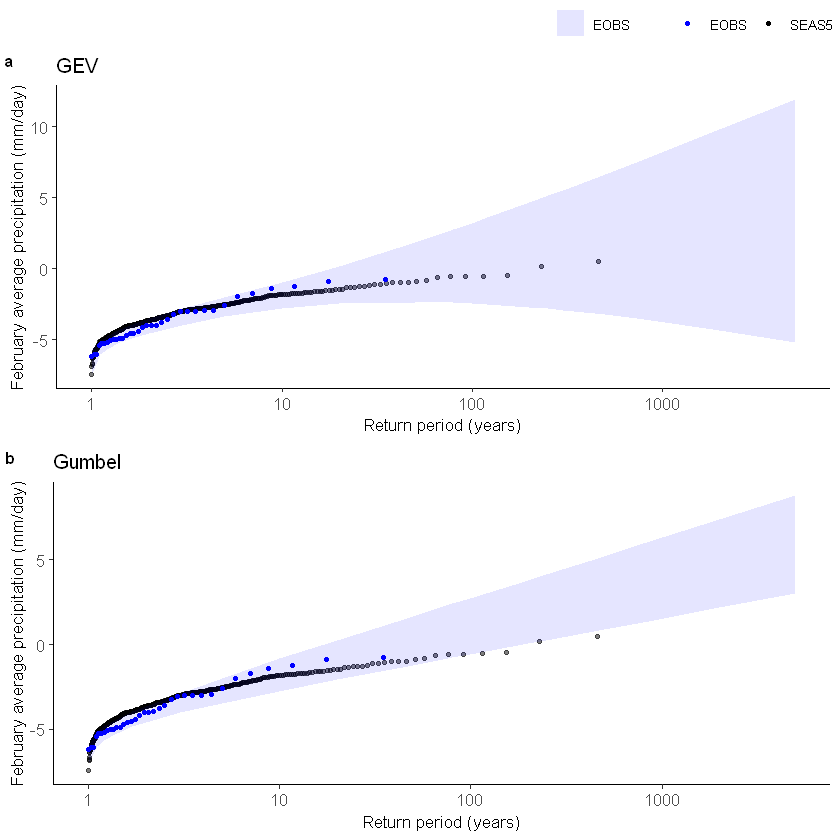

In [57]:
Gumbel1 <- EVT_plot(ensemble = SEAS5_Siberia_events_zoomed_forecasts$t2m, 
                    obs = ERA5_Siberia_events_zoomed_hindcast$t2m, 
                    main = "Gumbel", 
                    GEV_type = "Gumbel")

ggarrange(GEV1, Gumbel1,
  labels = c("a", "b"), # ,"c","d"),
  common.legend = T,
  font.label = list(size = 10, color = "black", face = "bold", family = NULL),
  ncol = 1, nrow = 2
) # %>%
# ggsave(filename = "graphs/Biascor.png",width =180,height = 180, units='mm',dpi=300)

And for the UK:

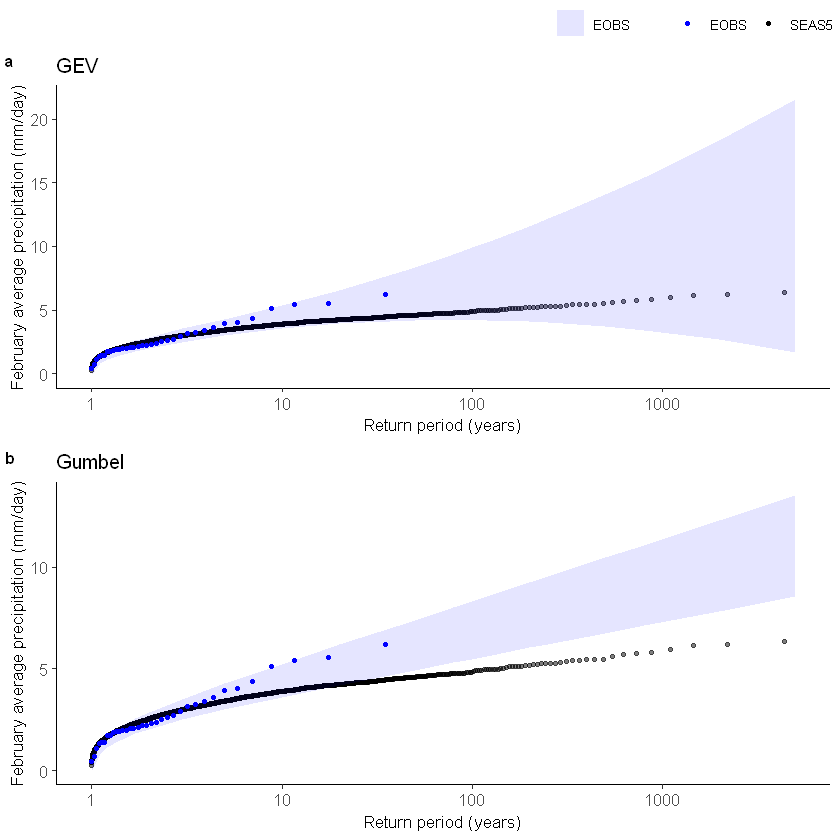

In [56]:
GEV1 <- EVT_plot(ensemble = SEAS5_UK_weighted_df$tprate, obs = EOBS_UK_weighted_df_hindcast$rr, main = "GEV", GEV_type = "GEV") # %>%
Gumbel1 <- EVT_plot(ensemble = SEAS5_UK_weighted_df$tprate, obs = EOBS_UK_weighted_df_hindcast$rr, main = "Gumbel", GEV_type = "Gumbel") # %>%

ggarrange(GEV1, Gumbel1,
  labels = c("a", "b"), # ,"c","d"),
  common.legend = T,
  font.label = list(size = 10, color = "black", face = "bold", family = NULL),
  ncol = 1, nrow = 2
) # %>%
